In [1]:
from datasets.data_handling import MergerWindowDataset

data_dir = "/mnt/d/waleed/G2Net/ET/EinsteinTelescope-WaveSim/data/"
dataset = MergerWindowDataset(data_dir, n_files=4, n_samples_per_file=10000)
print(len(dataset))

Found 4 HDF5 file(s) in /mnt/d/waleed/G2Net/ET/EinsteinTelescope-WaveSim/data/  (40000 samples)
40000


In [2]:
import numpy as np

item = np.random.choice(len(dataset))

print(dataset[item].keys())
print(dataset[item]["x"].shape)
print(dataset[item]["y"].shape)
print(dataset[item]["x_freq"].shape)
print(dataset[item]["theta"].shape)

dict_keys(['x', 'y', 'x_freq', 'theta'])
torch.Size([897, 2, 64])
torch.Size([57408, 2])
torch.Size([897, 2, 8])
torch.Size([4])


In [6]:
57408/100

574.08

Waveform 9026 has shape (57408, 2)
(57408,) (57408,)
Accepting waveform 😀


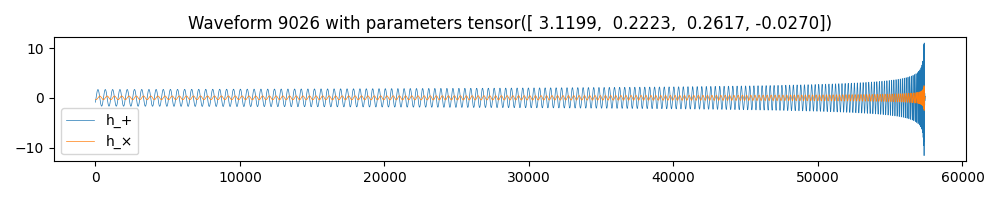

In [5]:
%matplotlib widget

import matplotlib.pyplot as plt

item = np.random.choice(len(dataset)) #4612, 11394, 30721

x = dataset[item]["x"]
T, C, K = x.shape
x = x.permute(0, 2, 1)
x = x.contiguous().view(T*K, C)
x = x.cpu().numpy()
print(f"Waveform {item} has shape {x.shape}")
hp, hx = x[..., 0], x[..., 1]
print(hp.shape, hx.shape)

def zcr(x):
    s = np.sign(x)
    return np.mean(s[1:] != s[:-1])

q = len(hp) // 4
z_early = zcr(hp[:q])
z_late  = zcr(hp[-q:])

if z_late <= 1.05 * z_early:
    print("Rejecting waveform 😢")
else:
    print("Accepting waveform 😀")
    #raise ValueError("No chirp behavior detected")


plt.figure(figsize=(10, 2))
plt.plot(hp, lw=0.5, label=r"h_+")
plt.plot(hx, lw=0.5, label=r"h_×")
plt.title(f"Waveform {item} with parameters {dataset[item]['theta']}")
plt.legend()
plt.tight_layout()

In [ ]:
plt.close()

In [ ]:
x = dataset[item]["x"]
T, C, K = x.shape
x = x.permute(0, 2, 1)
x = x.contiguous().view(T*K, C)
x = x.cpu().numpy()
hp, hx = x[..., 0], x[..., 1]
print(hp.shape, hx.shape)

In [ ]:
def zcr(x):
    s = np.sign(x)
    return np.mean(s[1:] != s[:-1])

q = len(hp) // 4
z_early = zcr(hp[:q])
z_late  = zcr(hp[-q:])

if z_late <= 1.05 * z_early:
    raise ValueError("No chirp behavior detected")


## Autoregressive Rollout

In [ ]:
import torch
from datasets.data_handling import GWDataModule
from models.lightning_module import GPTLightning

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Load the test dataset
dm = GWDataModule(data_dir="/mnt/d/waleed/G2Net/ET/EinsteinTelescope-WaveSim/data", n_files=4, n_samples_per_file=10000)
dm.setup("test")
test_loader = dm.test_dataloader()
data = next(iter(test_loader))

# Load the model
model = GPTLightning.load_from_checkpoint("logs/version_0/checkpoints/epoch=3-step=1252.ckpt")
model = model.gpt.to(device)
model.eval()

### Plot Raw Model Output

In [ ]:
%matplotlib widget
import numpy as np
import matplotlib.pyplot as plt

# Get a random waveform from the test dataset
item = np.random.choice(data["x"].shape[0])

x, y, x_freq, theta = data["x"].to(device), data["y"].to(device), data["x_freq"].to(device), data["theta"].to(device)
print(f"The shapes of the data are: x={x.shape}, y={y.shape}, x_freq={x_freq.shape}, theta={theta.shape}")

yhat = model(x, x_freq, is_causal=True, theta=theta)

y = y[item].cpu().numpy()
yhat = yhat[item].detach().cpu().numpy()

# Plot the waveform
plt.figure(figsize=(10, 2))
plt.plot(y[..., 0], label="True")
plt.plot(yhat[..., 0], marker="o", markersize=1, label="Predicted")
plt.title(f"Waveform {item} with parameters {theta}")
plt.legend()
plt.tight_layout()

### Fraction of Waveform as a Context

In [ ]:
%matplotlib widget
import numpy as np
import matplotlib.pyplot as plt

ks = 64

# Get a random waveform from the test dataset
item = np.random.choice(data["x"].shape[0])

# Full sequence lengths
x_full = data["x"].to(device) # shape (B, T, C, K)
y_full = data["y"].to(device) # shape (B, L=T*K, C)
x_freq_full = data["x_freq"].to(device) # shape (B, T, C, F)
theta = data["theta"].to(device) # shape (B, 4)

# Fraction of waveform to use as context (e.g. first 50%)
context_fraction = 0.85  # 0.0 to 1.0
T_full = x_full.shape[1]
T_context = max(1, int(T_full * context_fraction))

# Shorter context: only first T_context tokens
x = x_full[:, :T_context, :, :]           # [B, T_context, C, K]
x_freq = x_freq_full[:, :T_context, :, :]  # [B, T_context, C, F]

print(f"Full length: {T_full} tokens, context: {T_context} tokens ({context_fraction*100:.0f}%)")
print(f"Shapes: x={x.shape}, x_freq={x_freq.shape}")

yhat = model(x, x_freq, is_causal=True, theta=theta)  # [B, T_context*K, C]

# For comparison, take the same length from the true y
y_context = y_full[:, :T_context * ks, :]  # [B, T_context*K, C]

y_true = y_context[item].cpu().numpy()
yhat = yhat[item].detach().cpu().numpy()
# Now y_true and yhat are both (T_context*K, C) for the chosen item

# Plot the waveform
plt.figure(figsize=(10, 2))
plt.plot(y_true[..., 0], label="True")
plt.plot(yhat[..., 0], marker="o", markersize=1, label="Predicted")
plt.title(f"Waveform {item} with parameters {theta}")
plt.legend()
plt.tight_layout()

In [ ]:
%matplotlib widget
import numpy as np
import torch
import matplotlib.pyplot as plt

def freq_features_from_tokens(x, freq_keep_bins=8, freq_log1p=True):
    """
    Per-token FFT magnitude, matching data_handling.MergerWindowDataset._freq_features.
    x: [B, T, C, K] → [B, T, C, F]
    """
    mag = torch.fft.rfft(x, dim=-1).abs()
    if freq_log1p:
        mag = torch.log1p(mag)
    Fkeep = min(freq_keep_bins, mag.shape[-1])
    return mag[..., :Fkeep]


def autoregressive_rollout(
    model, data, item, context_fraction, future_fraction, device,
    kernel_size=64, stride=64, freq_keep_bins=8, freq_log1p=True, mode="autoregressive"
):
    ks = kernel_size
    x_full = data["x"].to(device)       # [B, T_full, C, K]
    y_full = data["y"].to(device)       # [B, T_full*K, C]
    theta  = data["theta"].to(device)   # [B, theta_dim]

    B, T_full, C, K = x_full.shape
    assert K == ks, f"Expected K==kernel_size ({ks}), got K={K}"

    T_context = max(1, int(T_full * context_fraction))

    # Remaining tokens after context:
    T_remain = T_full - T_context
    # Requested future tokens, but clamp to available:
    n_future_tokens = max(1, int(T_full * future_fraction))
    n_future_tokens = min(n_future_tokens, max(1, T_remain))

    L_context = T_context * K
    L_future  = n_future_tokens * K

    # Seed context
    x = x_full[item:item+1, :T_context].clone()  # [1, T_context, C, K]
    x_freq = freq_features_from_tokens(x, freq_keep_bins, freq_log1p)  # [1, T_context, C, F]
    theta_i = theta[item:item+1]


    start_future = (T_context - 1) * K
    y_true_future = y_full[item, start_future : start_future + L_future].cpu().numpy()
    y_true_full    = y_full[item].cpu().numpy()
    y_tokens = y_full[item, L_context:L_context + L_future].unfold(dimension=0, size=K, step=K) # [T, C, K]

    pred_list = []
    for i in range(n_future_tokens):
        with torch.no_grad():
            # MATCH TRAINING: causal attention
            out = model(x, x_freq, is_causal=True, theta=theta_i)  # [1, T*K, C]

        # Next token prediction = last K samples in out
        next_samples = out[:, -K:, :]                               # [1, K, C]
        y_teacher_tokens = y_tokens[i:i+1, :, :].unsqueeze(0) # [1, 1, C, K]
        pred_list.append(next_samples.squeeze(0).cpu())             # [K, C]

        # Append predicted token to x for next step
        next_token = next_samples.permute(0, 2, 1).unsqueeze(1)     # [1, 1, C, K]
        if mode == "teacher":
            x = torch.cat([x, y_teacher_tokens], dim=1)                       # [1, T+1, C, K]
        elif mode == "autoregressive":
            x = torch.cat([x, next_token], dim=1)                       # [1, T+1, C, K]
        else:
            raise NotImplementedError(f"Mode {mode} not implemented")
        x_freq = freq_features_from_tokens(x, freq_keep_bins, freq_log1p)

    y_pred_rollout = torch.cat(pred_list, dim=0).numpy()            # [L_future, C]

    # Safety: if clamping still results in mismatch for any reason
    L = min(len(y_pred_rollout), len(y_true_future))
    y_pred_rollout = y_pred_rollout[:L]
    y_true_future  = y_true_future[:L]

    return y_true_full, y_true_future, y_pred_rollout, L_context, L

# Example
item = np.random.choice(data["x"].shape[0])
context_fraction = 0.75
future_fraction = 0.06

y_true_full, y_true_future, y_pred_rollout, L_ctx, L_fut = autoregressive_rollout(
    model, data, item, context_fraction, future_fraction, device,
    kernel_size=64, stride=64, freq_keep_bins=8, freq_log1p=True,
    mode="autoregressive"
)

fig, ax = plt.subplots(2, 1, figsize=(10, 4), sharex=True)
t_full = np.arange(len(y_true_full))
t_fut = np.arange(L_ctx, L_ctx + len(y_pred_rollout))
ax[0].plot(t_full, y_true_full[:, 0], color="gray", alpha=0.7, label="True (full)")
ax[0].axvline(L_ctx, color="k", ls="--", alpha=0.7, label="Context end")
ax[0].plot(t_fut, y_true_future[:, 0], color="tab:orange", label="True future")
ax[0].plot(t_fut, y_pred_rollout[:, 0], color="tab:blue", ls="--", label="Pred future (rollout)")
ax[0].set_ylabel("h₊")
ax[0].legend(loc="upper right")
ax[0].grid(alpha=0.3)
#ax[0].set_xlim(55000, 58000)
ax[1].plot(t_full, y_true_full[:, 1], color="gray", alpha=0.7)
ax[1].axvline(L_ctx, color="k", ls="--", alpha=0.7)
ax[1].plot(t_fut, y_true_future[:, 1], color="tab:orange")
ax[1].plot(t_fut, y_pred_rollout[:, 1], color="tab:blue", ls="--")
ax[1].set_ylabel("h×")
ax[1].set_xlabel("Time samples")
ax[1].grid(alpha=0.3)
#ax[1].set_xlim(55000, 58000)
plt.suptitle(f"Rollout: {context_fraction*100:.0f}% context → {future_fraction*100:.0f}% future (item {item})")
plt.tight_layout()
plt.savefig("rollout.png", dpi=300)

In [ ]:
%matplotlib widget
import numpy as np
import torch
import matplotlib.pyplot as plt


def freq_features_from_tokens(x, freq_keep_bins=8, freq_log1p=True):
    """
    Per-token FFT magnitude, matching data_handling.MergerWindowDataset._freq_features.
    x: [B, T, C, K] → [B, T, C, F]
    """
    mag = torch.fft.rfft(x, dim=-1).abs()
    if freq_log1p:
        mag = torch.log1p(mag)
    Fkeep = min(freq_keep_bins, mag.shape[-1])
    return mag[..., :Fkeep]


def flatten_tokens_to_samples(tokens_1B_TCK: torch.Tensor) -> torch.Tensor:
    """
    tokens: [1, T, C, K] -> samples: [T*K, C]
    """
    assert tokens_1B_TCK.ndim == 4 and tokens_1B_TCK.shape[0] == 1
    T, C, K = tokens_1B_TCK.shape[1], tokens_1B_TCK.shape[2], tokens_1B_TCK.shape[3]
    # [1, T, C, K] -> [T, C, K] -> [T, K, C] -> [T*K, C]
    return tokens_1B_TCK.squeeze(0).permute(0, 2, 1).reshape(T * K, C)


def rollout(
    model,
    data,
    item: int,
    context_fraction: float,
    future_fraction: float,
    device,
    kernel_size: int = 64,
    freq_keep_bins: int = 8,
    freq_log1p: bool = True,
    mode: str = "free",                   # "free" or "teacher"
    max_context_tokens: int | None = None # optional sliding window for long rollouts
):
    """
    Autoregressive rollout on token space.

    data["x"] : [B, T_full, C, K]  (true tokens)
    data["y"] : [B, T_full*K, C]   (shifted-by-1 samples; NOT used for rollout alignment)
    data["theta"] : [B, theta_dim]

    Returns:
      true_full_samples: [T_full*K, C]
      true_future_samples: [L_future, C]
      pred_future_samples: [L_future, C]
      L_context (in samples)
      L_future (in samples)
    """
    x_full = data["x"].to(device)       # [B, T_full, C, K]  TRUE tokens
    theta  = data["theta"].to(device)   # [B, theta_dim]

    B, T_full, C, K = x_full.shape
    assert K == kernel_size, f"Expected K==kernel_size ({kernel_size}), got K={K}"
    assert 0 <= context_fraction <= 1, "context_fraction must be in [0,1]"
    assert 0 <= future_fraction <= 1, "future_fraction must be in [0,1]"
    assert mode in ("free", "teacher"), "mode must be 'free' or 'teacher'"

    T_context = max(1, int(T_full * context_fraction))

    # How many tokens can we actually predict?
    T_remain = T_full - T_context
    n_future_tokens = max(1, int(T_full * future_fraction))
    n_future_tokens = min(n_future_tokens, max(1, T_remain))

    L_context = T_context * K
    L_future  = n_future_tokens * K

    # Seed context (true tokens)
    x = x_full[item:item+1, :T_context].clone()  # [1, T_context, C, K]
    theta_i = theta[item:item+1]

    # Ground-truth future tokens (correct teacher-forcing tokens)
    gt_future_tokens = x_full[item:item+1, T_context:T_context + n_future_tokens].clone()  # [1, nF, C, K]

    pred_list = []
    for i in range(n_future_tokens):
        # optional sliding window to avoid exceeding model max length
        if (max_context_tokens is not None) and (x.shape[1] > max_context_tokens):
            x = x[:, -max_context_tokens:, :, :].contiguous()

        x_freq = freq_features_from_tokens(x, freq_keep_bins, freq_log1p)

        with torch.no_grad():
            out = model(x, x_freq, is_causal=True, theta=theta_i)   # [1, (T_in*K), C]

        # Predict NEXT token (last K samples correspond to next-token prediction)
        next_samples = out[:, -K:, :]                    # [1, K, C]
        pred_list.append(next_samples.squeeze(0).cpu())  # [K, C]

        if mode == "teacher":
            # Append TRUE next token
            x = torch.cat([x, gt_future_tokens[:, i:i+1]], dim=1)   # [1, T+1, C, K]
        else:
            # Append PRED next token
            next_token = next_samples.permute(0, 2, 1).unsqueeze(1) # [1, 1, C, K]
            x = torch.cat([x, next_token], dim=1)                   # [1, T+1, C, K]

    pred_future_samples = torch.cat(pred_list, dim=0).numpy()                      # [L_future, C]
    true_future_samples = flatten_tokens_to_samples(gt_future_tokens).cpu().numpy() # [L_future, C]
    true_full_samples   = flatten_tokens_to_samples(x_full[item:item+1]).cpu().numpy() # [T_full*K, C]

    # Safety
    L = min(len(pred_future_samples), len(true_future_samples))
    pred_future_samples = pred_future_samples[:L]
    true_future_samples = true_future_samples[:L]

    return true_full_samples, true_future_samples, pred_future_samples, L_context, L


# =========================
# Example
# =========================
item = np.random.choice(data["x"].shape[0])
context_fraction = 0.75
future_fraction = 0.05

# Choose mode: "teacher" (teacher forcing) or "free" (true autoregressive rollout)
mode = "free"

y_true_full, y_true_future, y_pred_rollout, L_ctx, L_fut = rollout(
    model=model,
    data=data,
    item=item,
    context_fraction=context_fraction,
    future_fraction=future_fraction,
    device=device,
    kernel_size=64,
    freq_keep_bins=8,
    freq_log1p=True,
    mode=mode,
    max_context_tokens=None,  # or e.g. 512 if your model has a max token length
)

fig, ax = plt.subplots(2, 1, figsize=(10, 4), sharex=True)
t_full = np.arange(len(y_true_full))
t_fut = np.arange(L_ctx, L_ctx + len(y_pred_rollout))

ax[0].plot(t_full, y_true_full[:, 0], color="gray", alpha=0.7, label="True (full)")
ax[0].axvline(L_ctx, color="k", ls="--", alpha=0.7, label="Context end")
ax[0].plot(t_fut, y_true_future[:, 0], color="tab:orange", label="True future")
ax[0].plot(t_fut, y_pred_rollout[:, 0], color="tab:blue", ls="--", label=f"Pred future ({mode})")
ax[0].set_ylabel("h₊")
ax[0].legend(loc="upper right")
ax[0].grid(alpha=0.3)
ax[0].set_xlim(50000, 58000)

ax[1].plot(t_full, y_true_full[:, 1], color="gray", alpha=0.7)
ax[1].axvline(L_ctx, color="k", ls="--", alpha=0.7)
ax[1].plot(t_fut, y_true_future[:, 1], color="tab:orange")
ax[1].plot(t_fut, y_pred_rollout[:, 1], color="tab:blue", ls="--")
ax[1].set_ylabel("h×")
ax[1].set_xlabel("Time samples")
ax[1].grid(alpha=0.3)
ax[1].set_xlim(50000, 58000)

plt.suptitle(f"{mode.capitalize()} rollout: {context_fraction*100:.0f}% context → {future_fraction*100:.0f}% future (item {item})")
plt.tight_layout()
plt.savefig("rollout.png", dpi=300)